Starting lock filling selection...
Step 1: 3 wide ships (using QAOA)
QAOA metrics for wide ships: {'valid_solution_probability': 100.0, 'near_optimal_probability': 12.096774193548388, 'best_objective_value': 28.5}
Step 2: Processing 5 medium ships and 2 narrow ships together

Total solution value: 60.50

Probability Metrics:
Valid Solution Probability: 50.67%
Near-Optimal Solution Probability: 0.16%
Best Solution Objective Value: 54.50
Ship Assignment Success Rate: 80.00%
Utilization Statistics:
Lock Length: 20m, Width: 10m
Total Used Length: 20m (100.00%)
Remaining Capacity: 0m


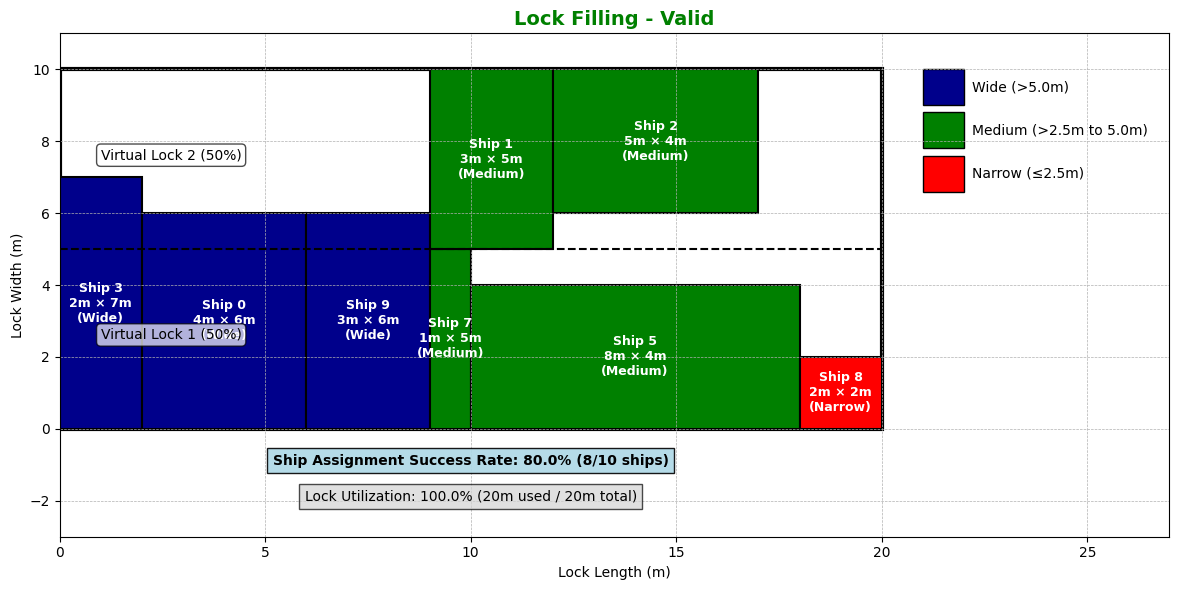

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pyqubo import Binary
from qat.lang.AQASM import Program, H, RZ, RX, CNOT
from qat.qpus import PyLinalg
from qat.core import Observable, Term

# Define problem parameters
K = 2                   # Number of locks (each lock is a knapsack)
L_x = 20                # Lock length (total capacity for ships in a lock)
L_y = 10                # Lock width (used for filtering ships by width)c

# Ship characteristics: lengths, widths, and waiting times (priority).
ship_lengths = np.array([4, 3, 5, 2, 6, 8, 7, 1, 2, 3])
ship_widths = np.array([6, 5, 4, 7, 1, 4, 3, 5, 2, 6])
waiting_times = np.array([10, 5, 8, 3, 7, 4, 3, 5, 2, 6])  # Higher waiting time = higher priority;

# Calculate ship value as a combination of width and waiting time.
alpha = 0.5              # Weight factor for waiting time in value computation.
ship_values = ship_widths + alpha * waiting_times

# Define penalty coefficients for our QUBO constraints.
C_assign = 20           # Penalty for not assigning a ship exactly once.
C_capacity = 20         # Penalty for violating lock capacity constraints.
C_onehot = 20           # Penalty to enforce a one-hot condition on slack bits.

num_slack = 4           # Number of slack bits per lock to account for unused capacity.

# Virtual lock ratio
virtual_lock_ratio = 0.5  # 50% for first virtual lock, 50% for second
def solve_knapsack_qaoa(ship_indices, remaining_capacity, lock_width, lock_count=K):
    # number of candidate ships provided by the indices
    N = len(ship_indices)
    if N == 0:
        # Return an empty assignment if there are no ships to process.
        return {k: [] for k in range(lock_count)}, remaining_capacity, {}, {}

    # Extract the ship lengths and values for only the selected ships.
    #preprocessing the ship data before the quantum optimization step.
    cand_lengths = ship_lengths[ship_indices]
    cand_values = ship_values[ship_indices]
    cand_widths = ship_widths[ship_indices]
    
    # Sort the ships by width within each width category
    sorted_indices = np.argsort(-cand_widths)
    ship_indices = np.array(ship_indices)[sorted_indices]
    cand_lengths = cand_lengths[sorted_indices]
    cand_values = cand_values[sorted_indices]
    cand_widths = cand_widths[sorted_indices]
    
    # Create binary variables
    ship_vars = [[Binary(f"x_{i}_{k}") for k in range(lock_count)] for i in range(N)]
    slack_vars = {k: [Binary(f"y_{k}_{l}") for l in range(num_slack)] for k in range(lock_count)}
    
    # Build the QUBO formulation
    #The objective function minimizes the negative of ship values (to maximize actual value)
    objective = - sum(ship_vars[i][k] * cand_values[i] for i in range(N) for k in range(lock_count))
    
    # Penalty:prevent assigning ships to multiple locks
    multi_assign_penalty = C_assign * sum(
        sum(ship_vars[i][k] * ship_vars[i][j] for k in range(lock_count) for j in range(k+1, lock_count))
        for i in range(N)
    )
    
    # Constraint: Each ship must be assigned exactly once.
    assign_constraint = C_assign * sum(
        (1 - sum(ship_vars[i][k] for k in range(lock_count)))**2 for i in range(N)
    )
    
    # Constraint: For each lock, the sum of assigned ship lengths plus the slack (unused capacity)
    # must equal the lock's remaining capacity.
    lock_capacity_constraint = C_capacity * sum(
        (sum(cand_lengths[i] * ship_vars[i][k] for i in range(N)) +
         sum((l+1) * slack_vars[k][l] for l in range(num_slack)) - remaining_capacity[k])**2
        for k in range(lock_count)
    )
    
    # Constraint: Enforce a one-hot condition for slack variables for each lock.
    slack_onehot = C_onehot * sum(
        (1 - sum(slack_vars[k][l] for l in range(num_slack)))**2 for k in range(lock_count)
    )
    
    # Full QUBO Hamiltonian combining objective and penalties.
    H_total = objective + assign_constraint + multi_assign_penalty + lock_capacity_constraint + slack_onehot
    
    # Compile the QUBO model from the Hamiltonian.
    model = H_total.compile()
    linear, quadratic, offset_ising = model.to_ising()  # Convert to Ising model form

    # Set up QAOA by converting the Ising model into an observable.
    n_vars = N*lock_count + lock_count*num_slack  # Total number of binary variables
    #creating observable
    observable = Observable(n_vars)
    
    # Create a mapping of variable names to their corresponding qubit indices.
    all_var_names = []
    for i in range(N):
        for k in range(lock_count):
            all_var_names.append(f"x_{i}_{k}")
    for k in range(lock_count):
        for l in range(num_slack):
            all_var_names.append(f"y_{k}_{l}")
    var_to_qubit = {var: idx for idx, var in enumerate(all_var_names)}
    
    # Add linear (Z) terms to the observable.
    for var, coeff in linear.items():
        observable.add_term(Term(float(coeff), "Z", [var_to_qubit[var]]))
    
    # Add quadratic (ZZ) interaction terms.
    for (var1, var2), coeff in quadratic.items():
        q1, q2 = var_to_qubit[var1], var_to_qubit[var2]
        observable.add_term(Term(float(coeff), "ZZ", [q1, q2]))
    
    # QAOA circuit design parameters and initialization.
    p = 12  # Number of QAOA layers
    betas = [np.pi/4 * (1. - i/p) for i in range(p)]
    gammas = [np.pi/4 * (1. + i)/p for i in range(p)]
    
    # Initialize the quantum program and allocate qubits.
    prog = Program()
    reg = prog.qalloc(n_vars)
    
    # Create a uniform superposition over all possible states.
    for qubit in reg:
        prog.apply(H, qubit)
    
    # Apply QAOA layers: alternate between the phase separator and mixer unitaries.
    for layer in range(p):
        # Apply the problem unitary based on the observable.
        for term in observable.terms:
            if term.op == "Z":
                q = term.qbits[0]
                prog.apply(RZ(2 * gammas[layer] * term.coeff), reg[q])
            elif term.op == "ZZ":
                q1, q2 = term.qbits
                prog.apply(CNOT, reg[q1], reg[q2])
                prog.apply(RZ(2 * gammas[layer] * term.coeff), reg[q2])
                prog.apply(CNOT, reg[q1], reg[q2])
        # Apply the mixer unitary to encourage exploration.
        for qubit in reg:
            prog.apply(RX(2 * betas[layer]), qubit)
    
    # Convert the program into a circuit.
    circuit = prog.to_circ()
    
    # Run the quantum circuit on a simulator and collect measurements.
    nshots = 5000      # Number of measurement shots
    qpu = PyLinalg()  # Quantum simulator
    job = circuit.to_job(nbshots=nshots)
    result = qpu.submit(job)
    
    # Count the occurrences of each bitstring result.
    bitstring_counts = {}
    for sample in result:
        bs = sample.state.bitstring
        bitstring_counts[bs] = bitstring_counts.get(bs, 0) + 1
    
    # Calculate total number of shots for probability calculations
    total_shots = sum(bitstring_counts.values())
    
    # Process ALL samples, not just the most frequent ones
    valid_solutions = []
    
    # Process all bitstrings
    for bitstring, count in bitstring_counts.items():
        # Decode the solution from the bitstring.
        assignment_bits = bitstring[:N*lock_count]
        assignment_array = np.array([int(bit) for bit in assignment_bits]).reshape(N, lock_count)
        
        # Check if this is a valid solution
        is_valid = True
        
        # Check if each ship is assigned at most once
        for i in range(N):
            if np.sum(assignment_array[i]) > 1:
                is_valid = False
                break
        
        if not is_valid:
            continue
            
        # Check capacity constraints
        temp_capacity = remaining_capacity.copy()
        for i in range(N):
            for k in range(lock_count):
                if assignment_array[i][k] == 1:
                    if temp_capacity[k] < cand_lengths[i]:
                        is_valid = False
                        break
                    temp_capacity[k] -= cand_lengths[i]
            if not is_valid:
                break
                
        # Check width constraints - ships must fit within lock width
        for i in range(N):
            for k in range(lock_count):
                if assignment_array[i][k] == 1 and cand_widths[i] > lock_width:
                    is_valid = False
                    break
            if not is_valid:
                break
        
        if is_valid:
            # Calculate objective value (we want to maximize ship values)
            objective_value = sum(cand_values[i] * assignment_array[i][k] for i in range(N) for k in range(lock_count))
            
            # Extract slack variables to compute the actual unused capacity
            slack_deductions = []
            for k in range(lock_count):
                start = N*lock_count + k*num_slack
                slack_bits = bitstring[start:start+num_slack]
                slack_val = sum((l+1)*int(bit) for l, bit in enumerate(slack_bits))
                slack_deductions.append(slack_val)
            
            valid_solutions.append((bitstring, objective_value, temp_capacity, slack_deductions, count))
    
    # Count the number of valid solutions
    valid_solution_count = sum(sol[4] for sol in valid_solutions)
    valid_solution_probability = (valid_solution_count / total_shots) * 100.0 if total_shots > 0 else 0.0
    
    # If no valid solutions found, return empty assignments
    if not valid_solutions:
        return {k: [] for k in range(lock_count)}, remaining_capacity, {}, {}
    
    # Sort valid solutions by objective value (highest first)
    sorted_valid_solutions = sorted(valid_solutions, key=lambda x: -x[1])
    
    # Get the best solution (highest objective value)
    best_bitstring, best_objective_value, best_capacity, _, _ = sorted_valid_solutions[0]
    
    # Calculate near-optimal solution probabilities
    near_optimal_solutions = [sol for sol in sorted_valid_solutions 
                                if sol[1] >= best_objective_value * 0.95]
    
    # Calculate the probability of getting a near-optimal solution
    near_optimal_count = sum(sol[4] for sol in near_optimal_solutions)
    near_optimal_probability = (near_optimal_count / total_shots) * 100.0 if total_shots > 0 else 0.0
    
    # Decode the best solution
    assignment_bits = best_bitstring[:N*lock_count]
    assignment_array = np.array([int(bit) for bit in assignment_bits]).reshape(N, lock_count)
    
    # Prepare final assignments
    assignments = {k: [] for k in range(lock_count)}
    assigned_ships = set()
    
    # Go through each ship and assign it to the lock indicated by the bitstring.
    for i in range(N):
        if np.sum(assignment_array[i]) > 0:
            k = np.argmax(assignment_array[i])  # Get the assigned lock (by maximum indicator)
            ship_idx = ship_indices[i]
            if ship_idx in assigned_ships:
                continue
        # Directly add the ship to its assigned lock -capacity constraints 
            assignments[k].append(ship_idx)
            assigned_ships.add(ship_idx)
    
    # Collect probability metrics in a dictionary to return
    probability_metrics = {
        'valid_solution_probability': valid_solution_probability,
        'near_optimal_probability': near_optimal_probability,
        'best_objective_value': best_objective_value
    }
    
    return assignments, best_capacity, assigned_ships, probability_metrics
def hybrid_lock_filling():
    print("Starting lock filling selection...")
    
    # Define width thresholds relative to lock width
    wide_threshold = 0.5 * L_y  # 5.0
    medium_threshold = 0.25 * L_y  # 2.5 (kept for visualization purposes only)
    
    # Initialize tracking variables
    final_assignments = []
    used_space = []  # Will hold tuples of (x_start, y_start, length, width) for visualization
    ship_categories = {'wide': [], 'medium': [], 'narrow': []}
    
    # Get all ship indices
    all_ship_indices = np.arange(len(ship_lengths))
    
    # STEP 1: First identify wide vs non-wide ships based on width threshold
    wide_ship_indices = [idx for idx in all_ship_indices if ship_widths[idx] > wide_threshold]
    non_wide_ship_indices = [idx for idx in all_ship_indices if ship_widths[idx] <= wide_threshold]
    
    # Sort non-wide ships by length only for first-degree ordering as suggested
    non_wide_ship_indices = sorted(non_wide_ship_indices, 
                                key=lambda idx: ship_lengths[idx],
                                reverse=True)  # Longer ships first
    
    # Track positions and assignments
    bottom_x = 0
    top_x = 0
    assigned_ship_indices = set()
    
    # STEP 2: Use QAOA to place wide ships that span the full width
    print(f"Step 1: {len(wide_ship_indices)} wide ships (using QAOA)")
    
    # For wide ships, we use a single lock as they span full width
    if wide_ship_indices:
        # Run QAOA for wide ships using full lock capacity
        wide_lock_assignments, final_capacities, assigned_wide_ships, wide_metrics = solve_knapsack_qaoa(
            wide_ship_indices, 
            {0: L_x},  # Single lock with full length
            L_y,       # Full width as these ships span the entire width
            1          # Single lock for wide ships
        )
        
        # Process assignments from QAOA
        for lock_idx, ship_indices in wide_lock_assignments.items():
            for ship_idx in ship_indices:
                if ship_idx in assigned_ship_indices:
                    continue
                    
                length = ship_lengths[ship_idx]
                if bottom_x + length <= L_x:  # Double-check if it fits
                    final_assignments.append(ship_idx)
                    used_space.append((bottom_x, 0, length, ship_widths[ship_idx]))
                    ship_categories['wide'].append(ship_idx)
                    assigned_ship_indices.add(ship_idx)
                    
                    # Update both row positions since wide ships span both rows
                    bottom_x = top_x = bottom_x + length
        
        print(f"QAOA metrics for wide ships: {wide_metrics}")
    
    # STEP 3: Split remaining space into two virtual knapsacks for non-wide ships
    # Calculate remaining capacity for each virtual lock
    remaining_capacity = {
        0: L_x - bottom_x,  # Bottom row
        1: L_x - top_x      # Top row
    }
    
    # Filter out already assigned ships
    non_wide_ship_indices = [idx for idx in non_wide_ship_indices if idx not in assigned_ship_indices]
    
    # Print counts for medium and narrow ships (for information only)
    medium_ships_count = len([idx for idx in non_wide_ship_indices 
                             if ship_widths[idx] > medium_threshold and ship_widths[idx] <= wide_threshold])
    narrow_ships_count = len([idx for idx in non_wide_ship_indices if ship_widths[idx] <= medium_threshold])
    
    print(f"Step 2: Processing {medium_ships_count} medium ships and {narrow_ships_count} narrow ships together")
    
    # STEP 4: Use QAOA to optimize placement of non-wide ships in the two virtual locks
    if non_wide_ship_indices and (remaining_capacity[0] > 0 or remaining_capacity[1] > 0):
        # Virtual lock width is half the total width
        virtual_lock_width = L_y / 2
        
        # Run QAOA to solve the two-lock knapsack problem for non-wide ships
        lock_assignments, final_capacities, assigned_ships, metrics = solve_knapsack_qaoa(
            non_wide_ship_indices, 
            remaining_capacity,
            virtual_lock_width,
            2  # Two virtual locks
        )
        
        # Process assignments from QAOA  
        for lock_idx, ship_indices in lock_assignments.items():
            for ship_idx in ship_indices:
                if ship_idx in assigned_ship_indices:
                    continue
                    
                assigned_ship_indices.add(ship_idx)
                final_assignments.append(ship_idx)
                
                # Place ships in appropriate rows based on virtual lock
                if lock_idx == 0:  # Bottom row
                    y_pos = 0
                    x_pos = bottom_x
                    bottom_x += ship_lengths[ship_idx]
                    # Still categorize as medium or narrow for visualization
                    ship_categories['medium' if ship_widths[ship_idx] > medium_threshold else 'narrow'].append(ship_idx)
                    used_space.append((x_pos, y_pos, ship_lengths[ship_idx], ship_widths[ship_idx]))
                else:  # Top row
                    y_pos = L_y - ship_widths[ship_idx]
                    x_pos = top_x
                    top_x += ship_lengths[ship_idx]
                    # Still categorize as medium or narrow for visualization
                    ship_categories['medium' if ship_widths[ship_idx] > medium_threshold else 'narrow'].append(ship_idx)
                    used_space.append((x_pos, y_pos, ship_lengths[ship_idx], ship_widths[ship_idx]))
    
    # Identify remaining ships
    remaining_ships = [idx for idx in all_ship_indices if idx not in assigned_ship_indices]
    
    # Sort them by value
    remaining_ships = sorted(remaining_ships, key=lambda idx: ship_values[idx], reverse=True)
    
    # Calculate remaining capacity
    remaining_bottom = L_x - bottom_x
    remaining_top = L_x - top_x
    
    # Try to fit more ships if possible
    for ship_idx in remaining_ships:
        length = ship_lengths[ship_idx]
        width = ship_widths[ship_idx]
        
        # Skip ships that are too wide for a single row
        if width > wide_threshold:
            continue
            
        # Try bottom row first
        if length <= remaining_bottom and width <= L_y/2:
            final_assignments.append(ship_idx)
            used_space.append((bottom_x, 0, length, width))
            ship_categories['medium' if width > medium_threshold else 'narrow'].append(ship_idx)
            bottom_x += length
            remaining_bottom -= length
            assigned_ship_indices.add(ship_idx)
        # Then try top row
        elif length <= remaining_top and width <= L_y/2:
            final_assignments.append(ship_idx)
            used_space.append((top_x, L_y - width, length, width))
            ship_categories['medium' if width > medium_threshold else 'narrow'].append(ship_idx)
            top_x += length
            remaining_top -= length
            assigned_ship_indices.add(ship_idx)
    
    # Calculate overall remaining capacity (the minimum of the two rows)
    remaining_capacity = min(remaining_bottom, remaining_top)
    
    # Calculate total solution value
    total_value = sum(ship_values[i] for i in final_assignments)
    print(f"\nTotal solution value: {total_value:.2f}")
    
    # Run a final QAOA with all ships to get overall metrics
    all_metrics = {}
    if final_assignments:
        # Create mapping for virtual locks
        virtual_lock_assignments = {0: [], 1: []}
        
        for idx, (x, y, _, width) in enumerate(used_space):
            if idx < len(final_assignments):
                ship_idx = final_assignments[idx]
                if width > wide_threshold:
                    # Wide ships go in both virtual locks
                    virtual_lock_assignments[0].append(ship_idx)
                    virtual_lock_assignments[1].append(ship_idx)
                elif y == 0:
                    # Bottom row ships go in virtual lock 0
                    virtual_lock_assignments[0].append(ship_idx)
                else:
                    # Top row ships go in virtual lock 1
                    virtual_lock_assignments[1].append(ship_idx)
    
        # Run one final QAOA to get the metrics
        _, _, _, all_metrics = solve_knapsack_qaoa(all_ship_indices, {0: L_x}, L_y, 1)
        
        # Print probability metrics
        print("\nProbability Metrics:")
        print(f"Valid Solution Probability: {all_metrics.get('valid_solution_probability', 0):.2f}%")
        print(f"Near-Optimal Solution Probability: {all_metrics.get('near_optimal_probability', 0):.2f}%")
        print(f"Best Solution Objective Value: {all_metrics.get('best_objective_value', 0):.2f}")
        
        # Print assignment success rate
        print(f"Ship Assignment Success Rate: {(len(final_assignments) / len(ship_lengths)) * 100:.2f}%")
        
        # Print utilization statistics
        print(f"Utilization Statistics:")
        print(f"Lock Length: {L_x}m, Width: {L_y}m")
        print(f"Total Used Length: {L_x - remaining_capacity}m ({((L_x - remaining_capacity) / L_x) * 100:.2f}%)")
        print(f"Remaining Capacity: {remaining_capacity}m")
    
    return final_assignments, remaining_capacity, used_space, all_metrics, ship_categories, virtual_lock_assignments
def visualize_lock_assignments(assignments, remaining_capacity, used_space):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Draw the lock boundary with a thicker line for emphasis
    ax.add_patch(plt.Rectangle((0, 0), L_x, L_y, edgecolor='black', facecolor='none', linewidth=3))
    
    # Add legend for ship width categories
    legend_x = L_x + 1
    legend_y = L_y - 1
    
    # Add legend manually with better colors and spacing
    ax.add_patch(plt.Rectangle((legend_x, legend_y), 1, 1, facecolor='darkblue', edgecolor='black'))
    ax.text(legend_x + 1.2, legend_y + 0.5, f"Wide (>{0.5*L_y}m)", va='center')
    
    ax.add_patch(plt.Rectangle((legend_x, legend_y - 1.2), 1, 1, facecolor='green', edgecolor='black'))
    ax.text(legend_x + 1.2, legend_y - 0.7, f"Medium (>{0.25*L_y}m to {0.5*L_y}m)", va='center')
    
    ax.add_patch(plt.Rectangle((legend_x, legend_y - 2.4), 1, 1, facecolor='red', edgecolor='black'))
    ax.text(legend_x + 1.2, legend_y - 1.9, f"Narrow (≤{0.25*L_y}m)", va='center')
    
    # Add title with capacity information
    plt.title(f"Lock Filling: Total Capacity {L_x}m, Remaining {remaining_capacity}m", 
              y=1.02, fontsize=12)
    
    # Calculate the used length for labeling
    used_length = L_x - remaining_capacity
    
    # Draw each ship according to its placement coordinates
    for idx, (x_start, y_start, length, width) in enumerate(used_space):
        ship_idx = assignments[idx] if idx < len(assignments) else None
        
        if ship_idx is None:
            continue
            
        # Choose color based on ship width
        if width > (0.5 * L_y):
            color = 'kblue'
            label = "Wide"
        elif width > (0.25 * L_y):
            color = 'green'
            label = "Medium"
        else:
            color = 'red'
            label = "Narrow"
        
        # Draw the ship as a rectangle
        rect = plt.Rectangle((x_start, y_start), length, width,
                             facecolor=color, edgecolor='black', 
                             linewidth=1.5)
        ax.add_patch(rect)
        
        # Label the ship with its index, dimensions, and category
        ax.text(x_start + length/2, y_start + width/2,
                f"Ship {ship_idx}\n{length}m × {width}m\n({label})",
                ha='center', va='center', color='white', fontsize=9, weight='bold')
    
    # Draw the unused portion of the lock with better visual distinction
    if remaining_capacity > 0:
        slack_start = L_x - remaining_capacity
        slack_rect = plt.Rectangle((slack_start, 0), remaining_capacity, L_y,
                                 facecolor='blue', alpha=0.3, hatch='//', edgecolor='black', linewidth=2)
        ax.add_patch(slack_rect)
        
        # Position the label in the center of the unused area with better visibility
        ax.text(slack_start + remaining_capacity/2, L_y/2,
              f"Unused\n{remaining_capacity}m", ha='center', va='center',
              color='red', fontsize=12, weight='bold', bbox=dict(facecolor='white', alpha=0.7))
    
    # Draw the virtual divider line at the ratio position
    divider_y = L_y / 2  # Middle of the lock
    plt.plot([0, L_x], [divider_y, divider_y], 'k--', linewidth=1.5)
    
    # Add virtual lock labels inside the lock area
    ax.text(1, divider_y/2, "Virtual Lock 1 (50%)", 
      ha='left', fontsize=10, 
      bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    ax.text(1, divider_y + (L_y-divider_y)/2, 
      "Virtual Lock 2 (50%)", 
      ha='left', fontsize=10,
      bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

    # Check if the solution is valid
    total_used = L_x - remaining_capacity
    valid = (total_used <= L_x)
    
    # Add a more prominent title
    ax.set_title(f"Lock Filling - {'Valid' if valid else 'Invalid'}",
                fontsize=14, color=('green' if valid else 'red'), weight='bold')
    
    # Set the axis limits exactly to the lock dimensions plus some margin
    ax.set_xlim(0, L_x + 7)  
    ax.set_ylim(-3, L_y + 1)
    
    # grid for better readability
    ax.grid(True, linestyle='--', linewidth=0.5)
    
    # Add labels to the axes
    ax.set_xlabel("Lock Length (m)", fontsize=10)
    ax.set_ylabel("Lock Width (m)", fontsize=10)
    
    # Add utilization stats directly on the plot
    used_percent = (total_used / L_x) * 100
    ax.text(L_x/2, -2, 
            f"Lock Utilization: {used_percent:.1f}% ({total_used}m used / {L_x}m total)",
            ha='center', fontsize=10, bbox=dict(facecolor='lightgray', alpha=0.7))
    
    # Add ship assignment rate directly on the plot
    assignment_rate = (len(assignments) / len(ship_lengths)) * 100
    ax.text(L_x/2, -1,
            f"Ship Assignment Success Rate: {assignment_rate:.1f}% ({len(assignments)}/{len(ship_lengths)} ships)",
            ha='center', fontsize=10, weight='bold', 
            bbox=dict(facecolor='lightblue', alpha=0.9))
    
    plt.tight_layout()
    return fig

# Main execution code
if __name__ == "__main__":
    # Run the lock filling algorithm
    final_assignments, remaining_capacity, used_space, metrics, ship_categories, virtual_lock_assignments = hybrid_lock_filling()
    
    # Create and display the visualization
    fig = visualize_lock_assignments(final_assignments, remaining_capacity, used_space)
    
    # Display the plot
    plt.show()